# Определение возраста покупателей

Заказчику - супермаркету - необходимо внедрить систему компьютерного зрения для обработки фотографий покупателей и сотрудников. Фотофиксация покупателей поможет проанализировать их покупки и скорректировать ассортимент, фотофиксация сотрудников поможет зафиксировать нарушения и добросовестность при продаже алкоголя. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека на набор фотографий людей с указанием возраста.



## Исследовательский анализ данных

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


<AxesSubplot:>

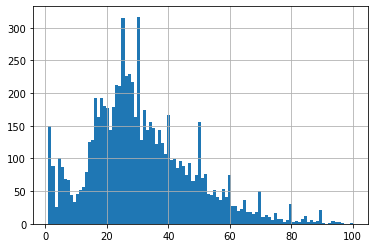

In [4]:
labels['real_age'].hist(bins=100)

На гистограмме преобладает возрастной контингент от 17 до 40 лет, но так же появляются резкие выбросы в следующих возрастах:
 - 1-2 лет (возможно родители приходят в магазин с детьми, дети не являются покупателями)
 - 23, 25, 40, 50, а далее наубыль идет количество людей по возрасту, но тем не менее есть выбросы в 60, 70, 80 и 90 лет. 

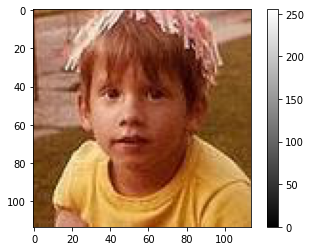

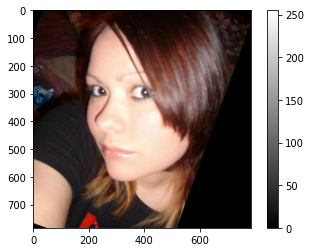

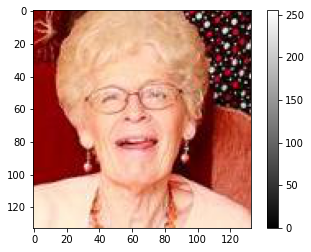

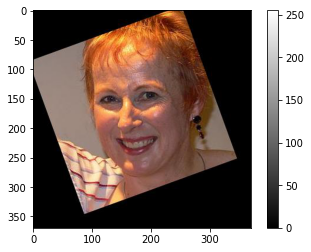

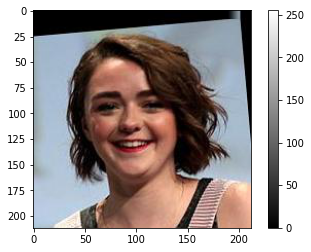

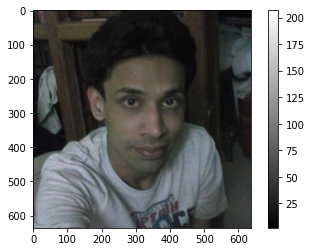

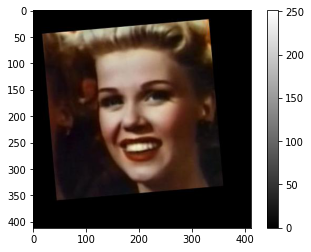

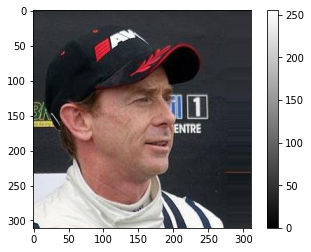

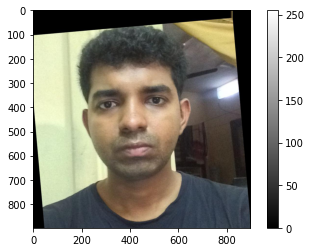

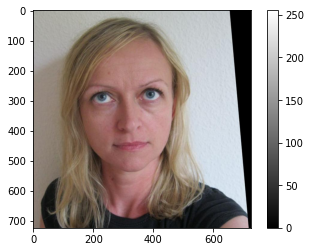

In [5]:
for i in range(0,10):
    image = Image.open('/datasets/faces/final_files/00000'+str(i)+'.jpg')
    array = np.array(image)
    plt.imshow(array, cmap='gray')
    plt.colorbar()
    plt.show()

На представленых фотографиях есть различие в размерах, где-то это 120х120, 800х800, где-то 500х500, 320х320 примерно, и так далее. Некоторые изображения изначально повернуты (как я предполагаю, для того, чтобы лицо смотрелось ровно). Также если посмотреть больше фотографий, то можно обнаружить черно-белые фото, а также фото на которых лицо частично закрыто разными предметами (очки, жевачка, микрофон и тд).

## Обучение модели

```python

import numpy as np
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)

    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

# < результат вывода на экран сюда >

178/178 - 66s - loss: 242.8451 - mae: 11.2282 - val_loss: 858.6248 - val_mae: 24.3057
Epoch 2/5
178/178 - 36s - loss: 63.3529 - mae: 6.0040 - val_loss: 516.5718 - val_mae: 17.4213
Epoch 3/5
178/178 - 36s - loss: 31.9461 - mae: 4.3768 - val_loss: 217.9956 - val_mae: 11.0403
Epoch 4/5
178/178 - 36s - loss: 19.8855 - mae: 3.4377 - val_loss: 128.4036 - val_mae: 8.5289
Epoch 5/5
178/178 - 36s - loss: 15.1212 - mae: 3.0227 - val_loss: 94.8671 - val_mae: 7.3398

  
60/60 - 9s - loss: 94.8671 - mae: 7.3398
Test MAE: 7.3398


```

## Анализ обученной модели

**Загрузка данных и исследовательский анализ**

Были получены и загружены данные с фотографиями и возрастами посетителей магазина. 
Были загружены обучающая и тестовые выборки с помощью ImageDataGenerator. 
Был проведем исследовательский анализ данных: получено распределение возрастов от 0 до 100 лет, наибольшее количество посетителей приходится на промежуток от 17 до 40 лет.
С помощью цикла for были визуализированы первые десять фотографий. 

**Обучение модели**
С помощью ImageDataGenerator производилась загрузка тренировочной и тестовой выборки, аугментация применялась - поворот на 90 градусов. В создании последовательной модели использовался алгоритм ResNet50 с оптимизатором Adam, learning_rate=0.0001. В модели было три слоя: 1 - костяк - с алгоритмом ResNet, 2 - сверточный слой GlobalAveragePooling2D, 3 - слой den, validation_steps = len(test_data).
